# Diabetes classification with logistic regression

Predict whether a person has **any** type of diabetes (yes/no) using a basic logistic regression model trained with NumPy only.


In [1]:
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix
# Load raw CSV: first column is diabetes status (0/1/2), remaining columns are features
DATA_PATH = Path("diabetes_binary_5050split_health_indicators_BRFSS2015.csv")

raw = np.loadtxt(DATA_PATH, delimiter=",", skiprows=1)

# Features and binary target (any non-zero diabetes -> 1, else 0)
X = raw[:, 1:]
y = (raw[:, 0] > 0).astype(np.float64)

print(f"Loaded {X.shape[0]} samples with {X.shape[1]} features")
print(f"Share of positive diabetes cases: {y.mean():.3f}")


Loaded 70692 samples with 21 features
Share of positive diabetes cases: 0.500


In [2]:
# Train / validation / test split
rng = np.random.default_rng(42)
indices = np.arange(len(X))
rng.shuffle(indices)

n = len(indices)
train_end = int(0.6 * n)
val_end = int(0.8 * n)

train_idx = indices[:train_end]
val_idx = indices[train_end:val_end]
test_idx = indices[val_end:]

X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

# Standardize features based on training set only
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
std[std == 0] = 1.0

X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

print(f"Train size: {len(X_train)} | Val size: {len(X_val)} | Test size: {len(X_test)}")


Train size: 42415 | Val size: 14138 | Test size: 14139


In [3]:
class LogisticRegressionGD:
    def __init__(self, lr=0.05, epochs=2000, reg=0.001):
        self.lr = lr
        self.epochs = epochs
        self.reg = reg
        self.w = None
        self.b = 0.0

    @staticmethod
    def _sigmoid(z):
        return 1.0 / (1.0 + np.exp(-z))

    def fit(self, X, y, verbose=False):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)

        for epoch in range(1, self.epochs + 1):
            linear = X @ self.w + self.b
            preds = self._sigmoid(linear)
            error = preds - y

            grad_w = (X.T @ error) / n_samples + self.reg * self.w
            grad_b = error.mean()

            self.w -= self.lr * grad_w
            self.b -= self.lr * grad_b

            if verbose and epoch % 500 == 0:
                loss = -np.mean(
                    y * np.log(preds + 1e-8) + (1 - y) * np.log(1 - preds + 1e-8)
                )
                print(f"epoch {epoch:4d} | loss {loss:.4f}")
        return self

    def predict_proba(self, X):
        return self._sigmoid(X @ self.w + self.b)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)


In [4]:
def evaluate_split(name, y_true, y_pred):
    acc = (y_pred == y_true).mean()
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    print(f"{name} accuracy : {acc:.3f}")
    print(f"{name} precision: {precision:.3f}")
    print(f"{name} recall   : {recall:.3f}\n")


# Grid search over a few basic hyperparameters using validation accuracy
learning_rates = [0.03, 0.05]
regs = [0.0, 0.001]
epochs_list = [200, 400]

best_val_acc = -1.0
best_params = None
best_model = None

print("Searching for good hyperparameters (compact grid)...\n")

for lr in learning_rates:
    for reg in regs:
        for epochs in epochs_list:
            model = LogisticRegressionGD(lr=lr, reg=reg, epochs=epochs)
            model.fit(X_train, y_train, verbose=False)

            val_preds = model.predict(X_val)
            val_acc = (val_preds == y_val).mean()

            print(f"lr={lr:.3f}, reg={reg:.4f}, epochs={epochs} -> val acc={val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = (lr, reg, epochs)
                best_model = model

print("\nBest hyperparameters (by validation accuracy):")
print(f"lr={best_params[0]:.3f}, reg={best_params[1]:.4f}, epochs={best_params[2]}")
print(f"Validation accuracy: {best_val_acc:.4f}\n")

# Tune decision threshold on the validation set for best accuracy
val_proba = best_model.predict_proba(X_val)
thresholds = np.linspace(0.3, 0.7, 41)

best_thresh = 0.5
best_thresh_acc = -1.0

for t in thresholds:
    preds_t = (val_proba >= t).astype(int)
    acc_t = (preds_t == y_val).mean()
    if acc_t > best_thresh_acc:
        best_thresh_acc = acc_t
        best_thresh = t

print(f"Best threshold on validation set: {best_thresh:.3f} (val acc={best_thresh_acc:.4f})\n")

# Evaluate final model on train, val, and test using tuned threshold
print("Final model performance with tuned hyperparameters and threshold:\n")

train_proba = best_model.predict_proba(X_train)
val_proba = best_model.predict_proba(X_val)
test_proba = best_model.predict_proba(X_test)

train_preds = (train_proba >= best_thresh).astype(int)
val_preds = (val_proba >= best_thresh).astype(int)
test_preds = (test_proba >= best_thresh).astype(int)

evaluate_split("Train", y_train, train_preds)
evaluate_split("Val", y_val, val_preds)
evaluate_split("Test", y_test, test_preds)

Searching for good hyperparameters (compact grid)...

lr=0.030, reg=0.0000, epochs=200 -> val acc=0.7517
lr=0.030, reg=0.0000, epochs=400 -> val acc=0.7534
lr=0.030, reg=0.0010, epochs=200 -> val acc=0.7517
lr=0.030, reg=0.0010, epochs=400 -> val acc=0.7531
lr=0.050, reg=0.0000, epochs=200 -> val acc=0.7528
lr=0.050, reg=0.0000, epochs=400 -> val acc=0.7539
lr=0.050, reg=0.0010, epochs=200 -> val acc=0.7527
lr=0.050, reg=0.0010, epochs=400 -> val acc=0.7536

Best hyperparameters (by validation accuracy):
lr=0.050, reg=0.0000, epochs=400
Validation accuracy: 0.7539

Best threshold on validation set: 0.440 (val acc=0.7570)

Final model performance with tuned hyperparameters and threshold:

Train accuracy : 0.747
Train precision: 0.714
Train recall   : 0.825

Val accuracy : 0.757
Val precision: 0.719
Val recall   : 0.837

Test accuracy : 0.749
Test precision: 0.713
Test recall   : 0.832



lr=0.030, reg=0.0000, epochs=200 -> val acc=0.7517


lr=0.030, reg=0.0000, epochs=400 -> val acc=0.7534
lr=0.030, reg=0.0010, epochs=200 -> val acc=0.7517


lr=0.030, reg=0.0010, epochs=400 -> val acc=0.7531
lr=0.050, reg=0.0000, epochs=200 -> val acc=0.7528


lr=0.050, reg=0.0000, epochs=400 -> val acc=0.7539
lr=0.050, reg=0.0010, epochs=200 -> val acc=0.7527


lr=0.050, reg=0.0010, epochs=400 -> val acc=0.7536

Best hyperparameters (by validation accuracy):
lr=0.050, reg=0.0000, epochs=400
Validation accuracy: 0.7539

Best threshold on validation set: 0.440 (val acc=0.7570)

Final model performance with tuned hyperparameters and threshold:

Train accuracy : 0.747
Train precision: 0.714
Train recall   : 0.825

Val accuracy : 0.757
Val precision: 0.719
Val recall   : 0.837

Test accuracy : 0.749
Test precision: 0.713
Test recall   : 0.832



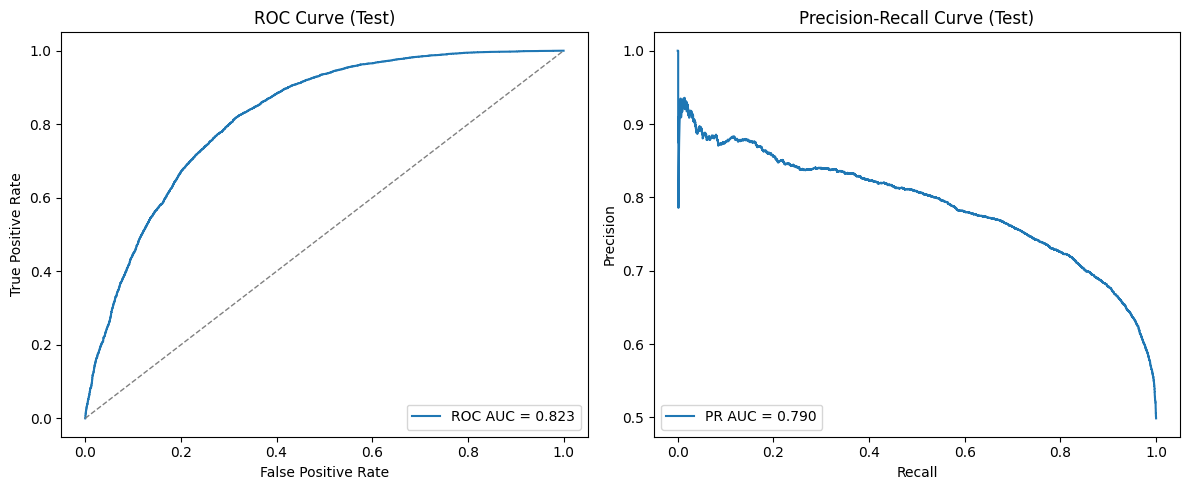

In [5]:
# ROC and Precision-Recall curves on the test set
fpr, tpr, _ = roc_curve(y_test, test_proba)
precision, recall, _ = precision_recall_curve(y_test, test_proba)
roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
ax[0].plot([0, 1], [0, 1], '--', color='gray', linewidth=1)
ax[0].set_title('ROC Curve (Test)')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend(loc='lower right')

ax[1].plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
ax[1].set_title('Precision-Recall Curve (Test)')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].legend(loc='lower left')

plt.tight_layout()
plt.show()


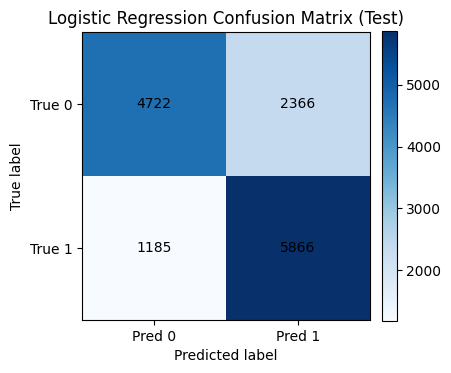

In [6]:
# Confusion matrix heatmap at tuned threshold (test set)
cm = confusion_matrix(y_test, (test_proba >= best_thresh).astype(int))
fig, ax = plt.subplots(figsize=(4.5, 4))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Pred 0', 'Pred 1'])
ax.set_yticklabels(['True 0', 'True 1'])
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
ax.set_title('Logistic Regression Confusion Matrix (Test)')
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()
